# Linear Classifier Trainer

In [1]:
import sys
sys.path.append("/media/alain/Data/Tesis/auxiliary_space/")

In [14]:
# Load features
import torch
import os
from easydict import EasyDict as edict
from torch.nn.functional import binary_cross_entropy_with_logits, relu
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from tqdm.notebook import tqdm
# Train linear classifier
import torch.nn as nn
from torch.optim import Adam
from metrics import *
from os.path import join
import random
import numpy as np

def update_metrics(all, new):
    for k,v in new.items():
        all[k].append(v)
    return all

def get_grouped_loss(losses, groups):
    #print(losses.shape)
    bs = losses.shape[0]
    g_losses, g_counts = group_data(losses, groups)
    loss = g_losses/bs
    return loss

in_dim = 2048
out_dim = 1

def train(model, data, opt):
    x = data['x'].cuda()
    y = torch.tensor(data['y']).unsqueeze(1).float().cuda()
    g = torch.tensor(data['g']).cuda()
    model.train()
    opt.zero_grad()
    logits = model(x)
    correct = ((logits>0)==y).sum()/(logits.shape[0])
    losses = l_f(logits, y, reduction="none").squeeze()
    loss = get_grouped_loss(losses.unsqueeze(1), g) # Apply any changes to the loss based on method
    mean_loss = loss.sum()
    mean_loss.backward()
    opt.step()
        
    return model

def evaluate(model, data):
    x = data['x'].cuda()
    y = torch.tensor(data['y']).unsqueeze(1).float().cuda()
    g = torch.tensor(data['g']).cuda()
    model.eval()
    with torch.no_grad():
        logits = model(x)
    evaluate_result = {'logits': []}
    evaluate_data= {'labels': [], 'groups': []}
    #print(logits.shape)
    evaluate_result['logits'] = logits.clone().cpu()
    evaluate_data['labels'] = y.clone().cpu() 
    evaluate_data['groups'] = g.clone().cpu() 

    logits = evaluate_result['logits']
    targets = evaluate_data['labels']
    groups = evaluate_data['groups'] # When using a single output dim

    metrics = calculate_metrics(evaluate_data, evaluate_result, args)

    return metrics

def train_model(args, model, data, n_iters= 1000):
    opt = Adam(model.parameters(), lr=0.001)
    all_metrics = dict()
    all_metrics['task_env1'] = {f"train_{k}": [] for k in args.metrics}
    all_metrics['eval'] = {f"val_{k}": [] for k in args.metrics}
    
    for i in tqdm(range(n_iters + 1), total=n_iters):
        model = train(model, data['train'],opt)
        train_metrics = evaluate(model,data['train'])
        train_metrics = {f"train_{k}":v for k, v in train_metrics.items()}
        all_metrics['task_env1'] = update_metrics(all_metrics['task_env1'], train_metrics)
        test_metrics = evaluate(model,data['test'])
        test_metrics = {f"val_{k}":v for k, v in test_metrics.items()}
        all_metrics['eval'] = update_metrics(all_metrics['eval'], test_metrics)
    return model, all_metrics

class LinearClassifier(nn.Module):
    def __init__(self,in_dim=100, out_dim=1):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, 2)
        self.cls = nn.Linear(2,out_dim)
    
    def forward(self, x):
        feats = relu(self.fc1(x))
        return self.cls(feats), feats

def set_random_state(args):
    os.environ['CUBLAS_WORKSPACE_CONFIG']=':4096:8'
    torch.use_deterministic_algorithms(True)
    torch.manual_seed(args.seed)
    torch.cuda.manual_seed(args.seed)
    torch.backends.cudnn.benchmark = False
    random.seed(args.seed)
    np.random.seed(args.seed)   

def save_stats(args, metrics):
    def make_human_readable_name(args):
        return f"X_mnistcifar_{args.corr}_True_{args.seed}_imgnet_FT"
    filename = make_human_readable_name(args)
    torch.save(metrics, join("../stats",filename))


## Preliminaries
- Set up data
- Set up model
- Set up loss function
- Define metrics

In [9]:


l_f = binary_cross_entropy_with_logits
args = edict()
args.metrics = ['acc','best_group_acc','worst_group_acc']
args.output_dims = 1

In [15]:
datasets = ['mnistcifar']
corrs = [0.0, 0.25, 0.5, 0.75, 0.9, 1.0]
seeds = [111,222]#,333,444,555,666,777,888,999,123]
for dataset in datasets:
    for corr in tqdm(corrs, total=len(corrs)):
        args.corr = corr
        train_data = torch.load(f"mnistcifar_{corr}_imgnet_2048_train.pth")
        test_data = torch.load(f"mnistcifar_{corr}_imgnet_2048_test.pth")
        data = {'train': train_data, 'test': test_data}
        for seed in tqdm(seeds, total=len(seeds)):
            args.seed = seed
            set_random_state(args)
            model = nn.Linear(2048,1).cuda()
            model, metrics = train_model(args, model,data,n_iters=3)
            save_stats(args, metrics)


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

## OTHER SHIT

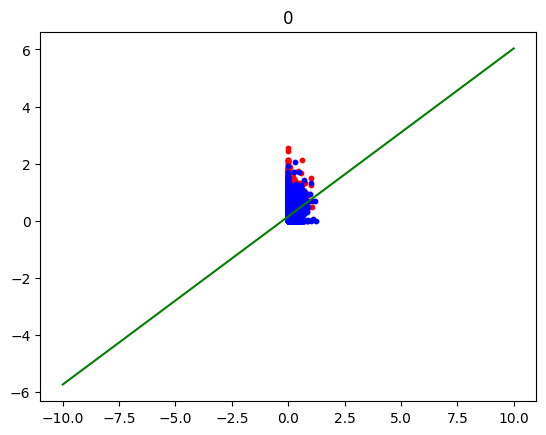

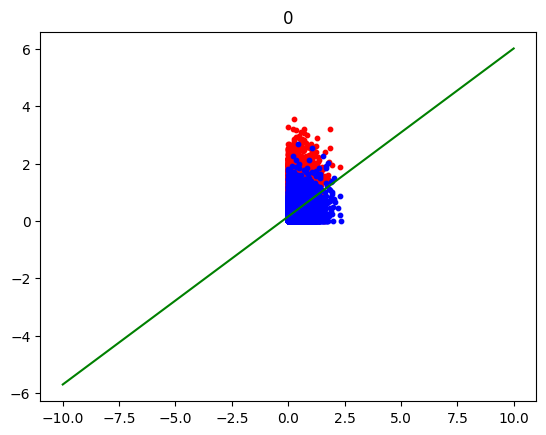

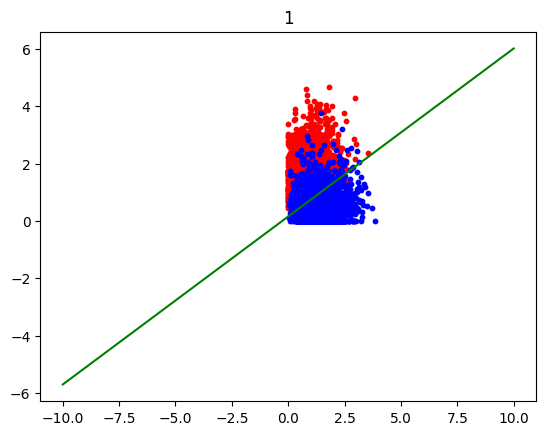

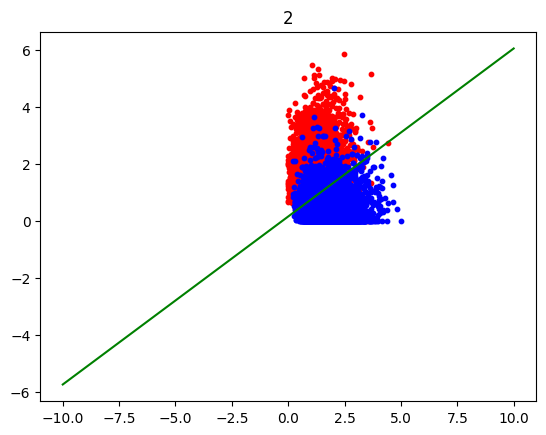

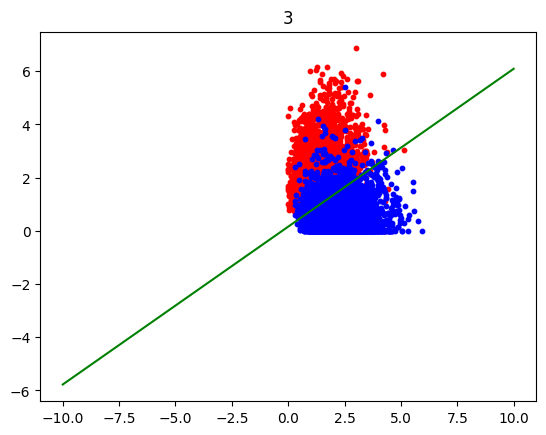

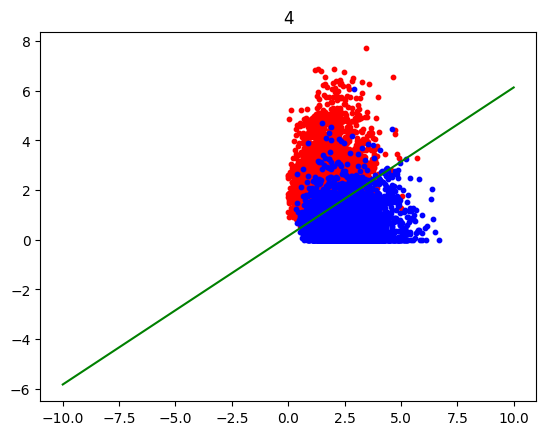

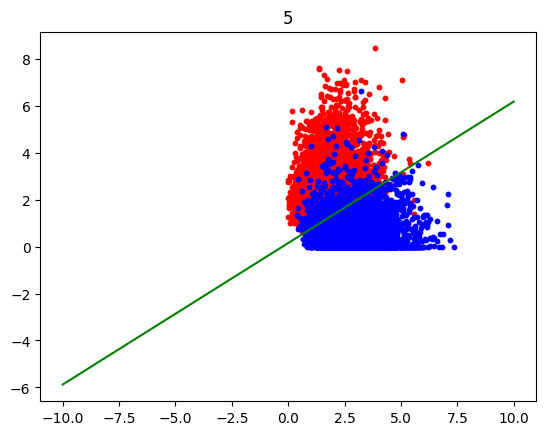

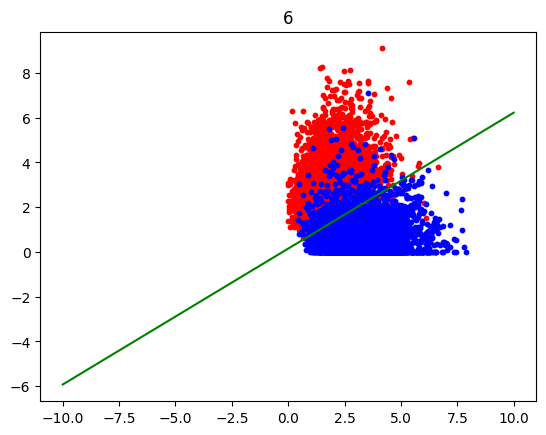

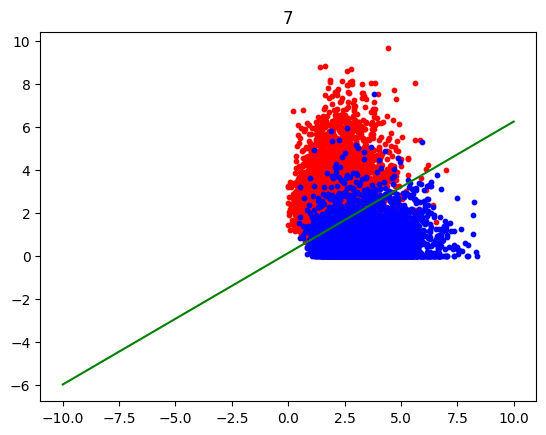

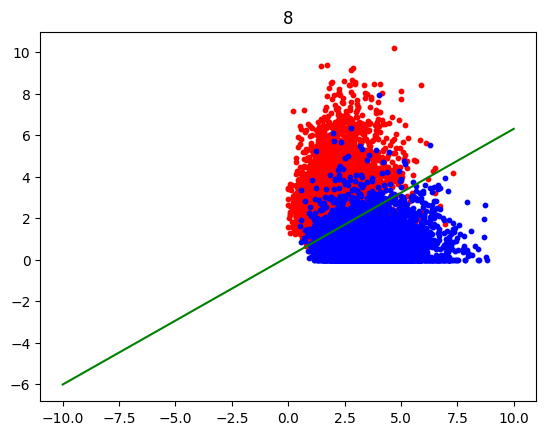

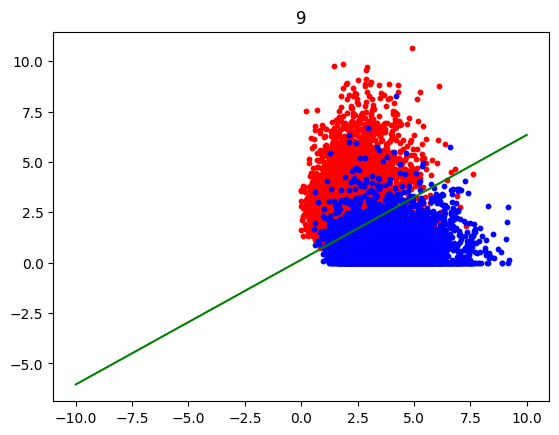

In [6]:
model = LinearClassifier(in_dim, out_dim).cuda()
opt = SGD(model.parameters(), lr=0.001)
l_f = binary_cross_entropy_with_logits
n_iters = 1000
data_points = []

# Set up the figure and axis
fig, ax = plt.subplots()
# Set the number of frames
num_frames = 10


def generate_data(model, feats):
    a, b = model.cls.weight[0].detach().clone().cpu()
    c = model.cls.bias[0].clone().detach().cpu()
    x_vals = [(feats[(y==0).squeeze()])[:,0].detach().clone().cpu(),
             (feats[(y==1).squeeze()])[:,0].detach().clone().cpu()]
    y_vals = [(feats[(y==0).squeeze()])[:,1].detach().clone().cpu(),
             (feats[(y==1).squeeze()])[:,1].detach().clone().cpu()]
    
    x_values = torch.linspace(-10, 10, 100)
    y_values = (-c - a*x_values)/b
    return {"feats":{"x": x_vals, "y": y_vals}, 
            "boundary": (x_values, y_values)}

def update(frame):
    for i in range(100+1):
        opt.zero_grad()
        logits, feats = model(x)
        correct = ((logits>0)==y).sum()/(logits.shape[0])
        loss = l_f(logits,y)
        loss.backward()
        opt.step()
    plt.clf()  # Clear the previous plot
    data = generate_data(model, feats)
    #print(data['feats'])
    plt.plot(*data['boundary'], color="green")
    plt.title(f"{frame}")
    plt.scatter(data['feats']["x"][0],data['feats']["y"][0], color="red",s =10)
    plt.scatter(data['feats']["x"][1],data['feats']["y"][1], color="blue",s =10)
    plt.show()

    #print(f"{i+1}- Loss: {loss} Acc: {100*correct}% ",end="")
    # Save the animation as a GIF (optional)

# Create the animation
animation = FuncAnimation(fig, update, frames=num_frames, interval=100)

animation.save('animated_plot.mp4', writer='ffmpeg')

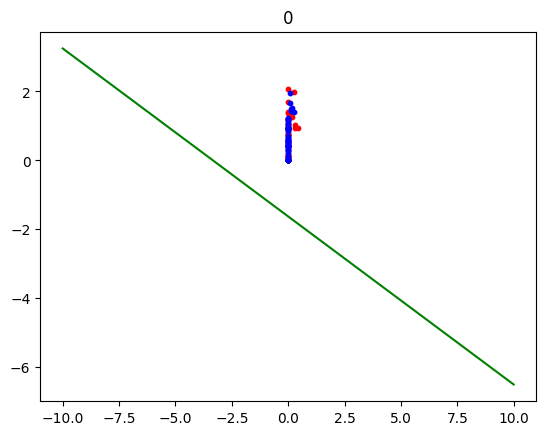

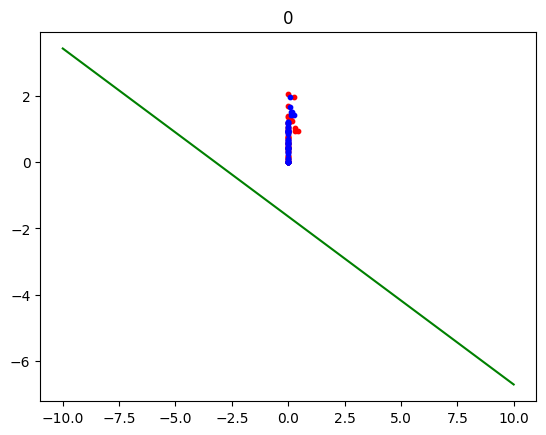

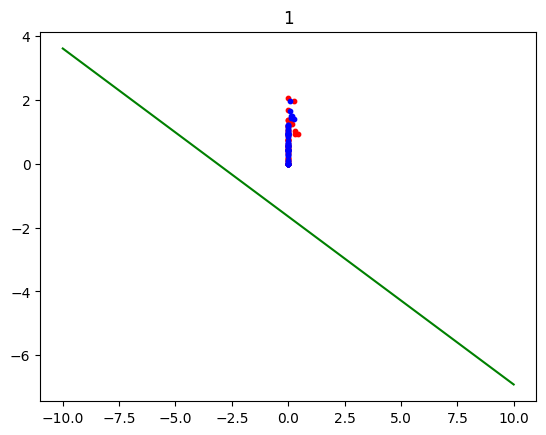

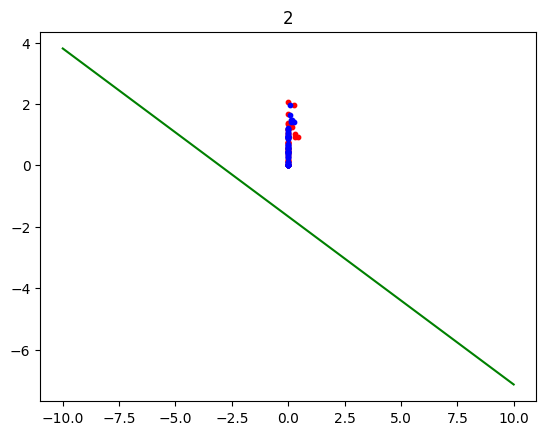

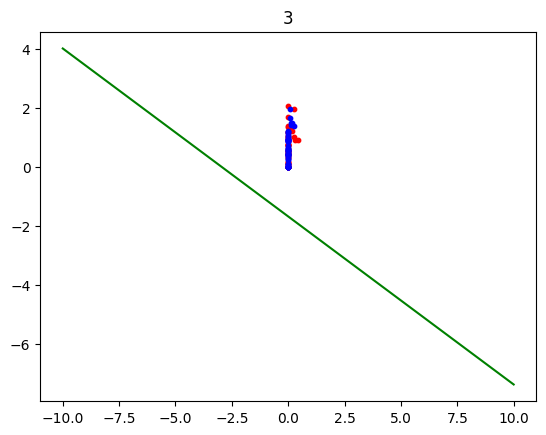

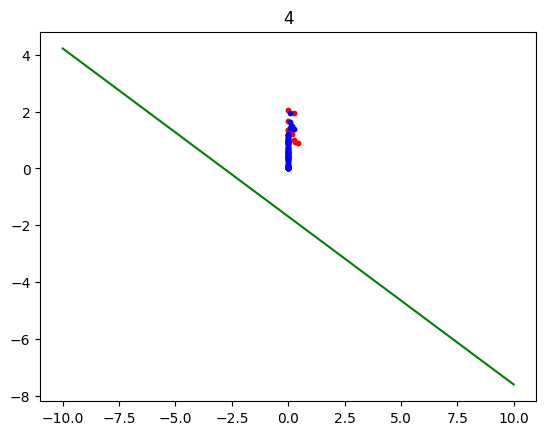

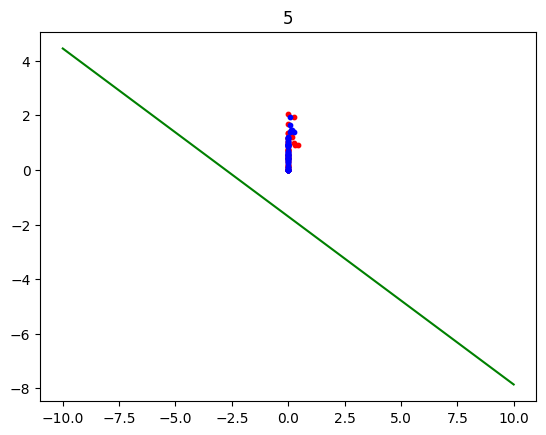

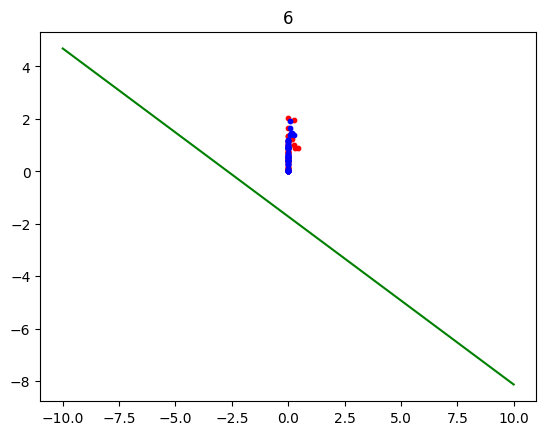

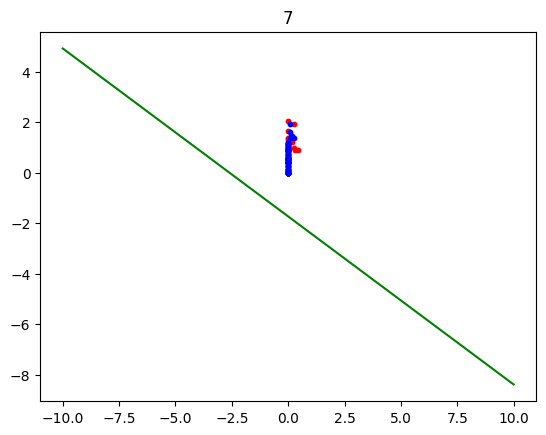

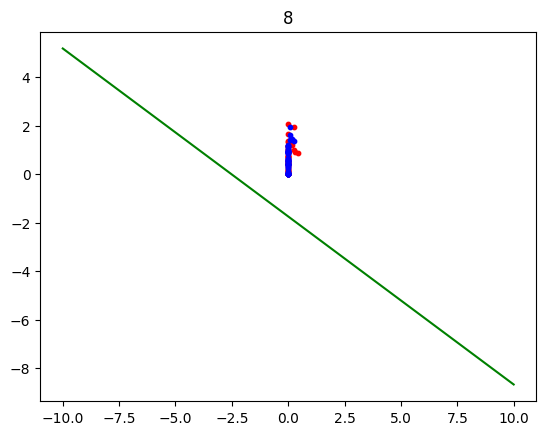

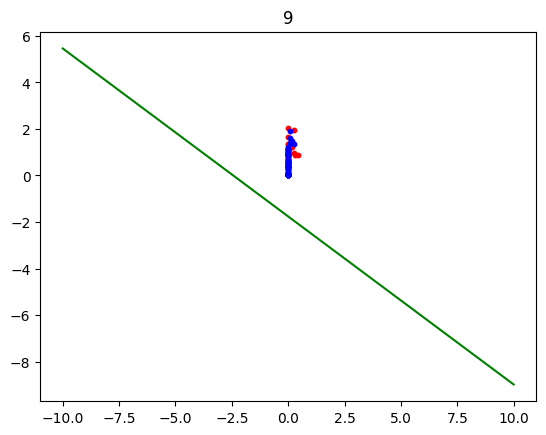

In [221]:
display(HTML(animation.to_jshtml()))


In [ ]:
def calculate_metrics(data, metrics, args):
    m = {}
    metric_functions = {'acc': mean_accuracy,
                        'worst_group_acc': worst_group_accuracy,
                        'best_group_acc': best_group_accuracy,
                        'loss': mean_loss,
                        'worst_group_loss': worst_group_loss,
                        'best_group_loss': best_group_loss
                        }
    metrics_to_calculate = args.metrics # acc, worst_group_acc, loss, worst_group_loss
    for metric in metrics_to_calculate:
        m[metric]= metric_functions[metric](data, metrics, args)
    return m


In [17]:
groups = torch.zeros((9000,1)).long()
num_classes = 1
one_hot_matrix = torch.eye(4)[groups]   

In [18]:
torch.eye(4).shape

torch.Size([4, 4])

In [19]:
one_hot_matrix.shape

torch.Size([9000, 1, 4])

In [20]:
one_hot_matrix[groups].shape

torch.Size([9000, 1, 1, 4])

In [5]:
a = torch.load("../../spur/stats/4_mnistcifar_0.0_True_111_erm")

In [7]:
a['eval']

{'train_acc': [],
 'train_loss': [],
 'train_worst_group_loss': [],
 'train_worst_group_acc': [],
 'train_best_group_loss': [],
 'train_best_group_acc': [],
 'val_acc': [0.5559999942779541,
  0.5040000081062317,
  0.5070000290870667,
  0.527999997138977,
  0.6129999756813049,
  0.7120000123977661,
  0.7229999899864197,
  0.7269999980926514,
  0.7350000143051147,
  0.746999979019165,
  0.7210000157356262,
  0.7200000286102295,
  0.7450000047683716,
  0.722000002861023,
  0.753000020980835,
  0.746999979019165,
  0.7689999938011169,
  0.75,
  0.7540000081062317,
  0.7760000228881836,
  0.7770000100135803,
  0.7789999842643738,
  0.7749999761581421,
  0.7739999890327454,
  0.7889999747276306,
  0.7910000085830688,
  0.796999990940094,
  0.796999990940094,
  0.8009999990463257,
  0.8100000023841858,
  0.8069999814033508,
  0.8090000152587891,
  0.8059999942779541,
  0.8130000233650208,
  0.8149999976158142,
  0.8140000104904175,
  0.8130000233650208,
  0.8190000057220459,
  0.8209999799728

In [16]:
a = torch.load("../stats/X_mnistcifar_0.0_True_111_imgnet_FT")

In [17]:
a

{'task_env1': {'train_acc': [0.5376666784286499,
   0.620888888835907,
   0.6228888630867004,
   0.6443333625793457],
  'train_best_group_acc': [0.9107142686843872,
   0.6933035850524902,
   0.9046754240989685,
   0.9223785996437073],
  'train_worst_group_acc': [0.15408118069171906,
   0.5482321977615356,
   0.3014121651649475,
   0.3265666365623474]},
 'eval': {'val_acc': [0.5389999747276306,
   0.6079999804496765,
   0.6179999709129333,
   0.6460000276565552],
  'val_best_group_acc': [0.9166666865348816,
   0.6336206793785095,
   0.8901960849761963,
   0.9254902005195618],
  'val_worst_group_acc': [0.16867469251155853,
   0.5823293328285217,
   0.33712121844291687,
   0.3598484992980957]}}